<a href="https://colab.research.google.com/github/PolMix/nems_ai/blob/main/Classic%20ML/Classic_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lib import

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

# Удобства
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Модели
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.base import clone

!pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetRegressor

from xgboost import XGBRegressor

!pip3 install optuna
import optuna

# Метрики качества
from time import time

from sklearn.metrics import r2_score, mean_squared_error

# Обработка датасета, кроссвалидация
from sklearn.model_selection import train_test_split, KFold, cross_validate

# Нормировка датасета
from sklearn.preprocessing import RobustScaler, StandardScaler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 55.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.13.1 whi

# Скачивание данных и скриптов

Загружаем датасет с GitHub:

In [3]:
import zipfile
import os

!wget --no-check-certificate \
    "https://github.com/PolMix/nems_ai/archive/refs/heads/main.zip" \
    -O "/tmp/data.zip"


zip_ref = zipfile.ZipFile('/tmp/data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2023-06-13 12:35:33--  https://github.com/PolMix/nems_ai/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/PolMix/nems_ai/zip/refs/heads/main [following]
--2023-06-13 12:35:33--  https://codeload.github.com/PolMix/nems_ai/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/data.zip’

/tmp/data.zip           [        <=>         ]  17.24M  6.62MB/s    in 2.6s    

2023-06-13 12:35:36 (6.62 MB/s) - ‘/tmp/data.zip’ saved [18081079]



In [4]:
%cd '/tmp/nems_ai-main/Data Processed'
filename = 'Dataset_Processed.csv'
df = pd.read_csv(filename)
df = df.drop(columns='Unnamed: 0')
df.head()

/tmp/nems_ai-main/Data Processed


,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa),M1 Eigenfrequency (Hz),M1 Quality factor,...,M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 Noise (kg^2/s^3),M3 TED (W),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 Noise (kg^2/s^3),M4 TED (W)
0,10.666186,759.454713,192.911166,46.497924,19.089801,465.822644,28.323179,9.003567e+08,6.415102e+07,1.336133e+04,...,2.909667e+08,1.143351e+04,2.560363e-15,6.037978e-22,3.409430e-12,3.964520e+08,1.013999e+04,8.780197e-16,3.181145e-22,4.959458e-12
1,105.195552,890.696186,209.252268,37.407275,3.716553,314.636835,30.305477,5.090849e+08,2.569354e+06,7.177442e+06,...,8.224139e+06,5.740452e+06,3.281744e-14,8.720428e-28,1.367533e-11,1.152226e+07,5.003229e+06,3.291971e-14,1.406151e-27,1.583936e-11
2,10.310316,221.113532,195.903798,37.079461,0.027053,251.500693,26.675832,6.351363e+08,3.353110e+07,2.675673e+06,...,1.267642e+08,1.891218e+06,7.206070e-16,6.788349e-28,2.254001e-12,1.923697e+08,1.709827e+06,7.147747e-16,1.130223e-27,2.477637e-12
3,18.683573,282.662136,207.614117,18.750307,0.496423,172.245797,2.647445,0.000000e+00,1.049078e+07,8.772643e+06,...,4.475571e+07,8.332783e+06,1.623836e-15,6.849769e-28,2.943955e-12,7.057576e+07,8.000998e+06,1.616668e-15,1.119973e-27,3.081568e-12
4,121.747842,991.550766,102.506945,29.297485,2.037235,415.471216,18.419812,8.374213e+08,2.649739e+06,7.314592e+06,...,8.269131e+06,6.082613e+06,2.259615e-14,2.331664e-28,2.518650e-11,1.138111e+07,5.405428e+06,2.267905e-14,3.624442e-28,2.982471e-11


Скачивание файла с тестовым устройством из края распределений параметров:

In [5]:
filename_test = 'Data_Processed_Boundary_Test.csv'
df_test = pd.read_csv(filename_test)
df_test = df_test.drop(columns='Unnamed: 0')
df_test.head()

,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),...,M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 Noise (kg^2/s^3),M3 TED (W),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 Noise (kg^2/s^3),M4 TED (W)
0,821.402113,897.519396,200.0,36.102266,2.248089,924.978487,39.775523,169003.789805,53781.219971,2.581146e-13,...,5.089901e+05,53640.722509,2.582148e-13,4.490996e-28,1.441984e-11,6.809541e+05,53577.353352,2.583005e-13,6.009473e-28,2.286573e-11
1,187.634453,482.065578,150.0,19.450374,161.773060,911.580688,10.599196,512665.917301,27829.840781,2.167964e-14,...,1.616819e+06,25729.966624,2.199621e-14,3.120787e-25,1.475224e-11,2.243525e+06,24670.596346,2.212375e-14,4.356675e-25,1.758884e-11
2,638.204045,242.947138,100.0,24.144951,3.181935,455.886263,15.074379,221111.869936,14575.916394,2.871363e-14,...,6.636297e+05,14574.507206,2.871555e-14,5.640215e-28,7.054148e-13,8.851790e+05,14573.764249,2.871377e-14,7.522689e-28,1.155275e-12
3,910.105786,675.544397,200.0,43.676386,107.099808,914.705274,8.740595,124047.991251,39709.542285,2.224241e-13,...,3.731338e+05,38154.086830,2.224716e-13,1.462375e-26,7.550186e-12,4.986630e+05,37426.945624,2.225221e-13,1.954104e-26,1.220765e-11
4,665.998773,627.258997,200.0,26.364768,0.970622,659.057305,0.787551,201641.652944,37627.851275,1.412254e-13,...,6.068425e+05,37612.298667,1.412640e-13,2.752680e-28,4.751424e-12,8.113547e+05,37608.207889,1.412993e-13,3.680917e-28,1.052563e-11


# Подготовка данных

Делаем несколько действий:
- разбиваем датасет на тренировочную + валидационную часть и тестовую часть
- разбиваем трен-вал датасет на X и Y данные
- разбиваем тест датасет на X и Y данные

In [6]:
len_test = 0.2 # доля объектов на тренировку и валидацию из изначального датасета
len_val = 0.2 # доля объектов на валидацию из трен-вал датасета

mode_number = 4

df_trainval, df_test = train_test_split(df, test_size=len_test, random_state=42, shuffle=True)
df_train, df_val = train_test_split(df_trainval, test_size=len_val, random_state=42, shuffle=True)

Разделение данных на тренировочную, валидационную и тестовую части:

Разбиение подвыборок на X и Y данные:

In [7]:
%cd '/tmp/nems_ai-main/Scripts'
from dataset_preprocessing_pandas import split_df

x_train, y_train = split_df(df_train, num_common=8)
x_val, y_val = split_df(df_val, num_common=8)
x_test, y_test = split_df(df_test, num_common=8)

print('Dataset has been split into parts with the following shapes:')
print(f'x_train: {x_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'x_val: {x_val.shape}')
print(f'y_val: {y_val.shape}')
print(f'x_test: {x_test.shape}')
print(f'y_test: {y_test.shape}')

/tmp/nems_ai-main/Scripts
Dataset has been split into parts with the following shapes:
x_train: (3141, 8)
y_train: (3141, 20)
x_val: (786, 8)
y_val: (786, 20)
x_test: (982, 8)
y_test: (982, 20)


In [8]:
x_test.head()

,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa)
4153,49.308200,782.896481,188.132818,26.635533,39.776275,218.106779,14.971359,3.142405e+08
3543,192.137428,518.376180,207.654824,15.361588,14.690520,358.705745,17.274668,0.000000e+00
907,58.299798,519.390602,200.345532,16.901881,264.175611,263.652628,23.487618,0.000000e+00
2522,65.228068,534.583721,199.844154,17.919077,10.055709,590.683389,30.865407,5.533608e+08
3107,419.836754,346.292481,209.354864,44.989361,1.196841,283.956739,17.091576,3.264575e+08


In [9]:
y_train.head()

,M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),M1 Noise (kg^2/s^3),M1 TED (W),M2 Eigenfrequency (Hz),M2 Quality factor,M2 Effective mass (kg),M2 Noise (kg^2/s^3),M2 TED (W),M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 Noise (kg^2/s^3),M3 TED (W),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 Noise (kg^2/s^3),M4 TED (W)
3781,8.234588e+05,2.205309e+06,3.358069e-14,1.007442e-29,2.962872e-12,1.652589e+06,2.179432e+06,3.360062e-14,2.047043e-29,1.705975e-11,2.492992e+06,2.138282e+06,3.363194e-14,3.150402e-29,2.224337e-11,3.350131e+06,1.953502e+06,3.366659e-14,4.638795e-29,2.730320e-11
2200,3.620573e+07,1.264815e+05,1.630021e-15,2.647570e-23,3.616754e-12,8.950608e+07,8.741688e+04,1.780460e-15,1.034411e-22,3.956188e-12,1.634791e+08,6.489439e+04,1.773305e-15,2.534792e-22,4.171862e-12,2.560639e+08,5.143171e+04,1.759506e-15,4.970636e-22,4.369109e-12
4798,4.018177e+06,6.465237e+07,1.022956e-14,9.568429e-31,1.024539e-11,8.167046e+06,6.037550e+07,1.029027e-14,2.094931e-30,1.748103e-11,1.256789e+07,5.489475e+07,1.036000e-14,3.569687e-30,2.206222e-11,1.732588e+07,4.940941e+07,1.039743e-14,5.487195e-30,2.605582e-11
963,4.495736e+07,4.020745e+04,2.375713e-15,3.250626e-26,3.480341e-12,1.127357e+08,3.688876e+04,2.603435e-15,9.736272e-26,3.848615e-12,2.067481e+08,3.532490e+04,2.583663e-15,1.850441e-25,4.200149e-12,3.232575e+08,3.457247e+04,2.556074e-15,2.924626e-25,4.656986e-12
3965,3.016408e+06,1.090949e+09,2.947338e-14,5.105655e-33,9.305841e-13,6.131970e+06,1.006085e+09,2.964966e-14,1.132194e-32,5.494210e-12,9.438750e+06,8.997463e+08,2.985198e-14,1.962020e-32,1.288137e-11,1.301669e+07,8.200638e+08,2.995975e-14,2.979387e-32,1.521141e-11


Выполняем логарифмирование и скейлинг:

In [10]:
from dataset_preprocessing_pandas import Scaler as Scaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()

mode_number = 4
s = Scaler(scaler_x, scaler_y, mode_number)
s.fit(x_train=x_train, y_train=y_train)

x_train, y_train = s.transform(x_train, y_train)
x_val, y_val = s.transform(x_val, y_val)
x_test, y_test = s.transform(x_test, y_test)

In [11]:
y_test.describe()

,M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),M1 Noise (kg^2/s^3),M1 TED (W),M2 Eigenfrequency (Hz),M2 Quality factor,M2 Effective mass (kg),M2 Noise (kg^2/s^3),M2 TED (W),M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 Noise (kg^2/s^3),M3 TED (W),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 Noise (kg^2/s^3),M4 TED (W)
count,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000
mean,0.008397,-0.014167,-0.006174,0.025109,0.013023,0.008054,-0.013916,-0.006343,0.024551,0.002942,0.007557,-0.014963,-0.006363,0.024660,-0.004944,0.007016,-0.007708,-0.006983,0.021198,-0.008800
std,0.988296,0.961995,0.980944,0.988541,0.984973,0.989626,0.963986,0.980410,0.990055,0.982179,0.990671,0.964596,0.980489,0.990604,0.972298,0.991183,0.973177,0.982377,0.995477,0.968027
min,-2.210503,-2.607106,-2.922469,-2.305750,-3.902680,-2.127390,-2.584861,-2.962526,-2.293187,-4.179475,-2.081414,-2.565005,-2.962160,-2.289673,-4.170642,-2.053933,-2.643954,-2.904239,-2.465779,-4.017885
25%,-0.764214,-0.696085,-0.714197,-0.681071,-0.555324,-0.764181,-0.706019,-0.699185,-0.682143,-0.422503,-0.769533,-0.703914,-0.700720,-0.686954,-0.489975,-0.775452,-0.694660,-0.682452,-0.697956,-0.514381
50%,-0.023415,-0.068124,-0.015231,0.061847,0.294927,-0.050238,-0.053054,-0.015728,0.057023,0.173135,-0.075644,-0.052964,-0.015262,0.053236,0.093081,-0.088919,-0.047806,-0.002947,0.056189,0.043985
75%,0.712678,0.682357,0.743511,0.773055,0.726739,0.691099,0.700989,0.737272,0.761989,0.654429,0.713913,0.700747,0.735649,0.751653,0.632641,0.720316,0.716392,0.735474,0.738864,0.655614
max,2.345348,2.479744,2.259412,2.881269,2.064679,2.397605,2.476387,2.267635,2.878661,2.222553,2.403320,2.453312,2.266518,2.853652,2.301370,2.239074,3.003916,2.242780,2.784347,2.308940


# Визуализация распределения нормированных параметров

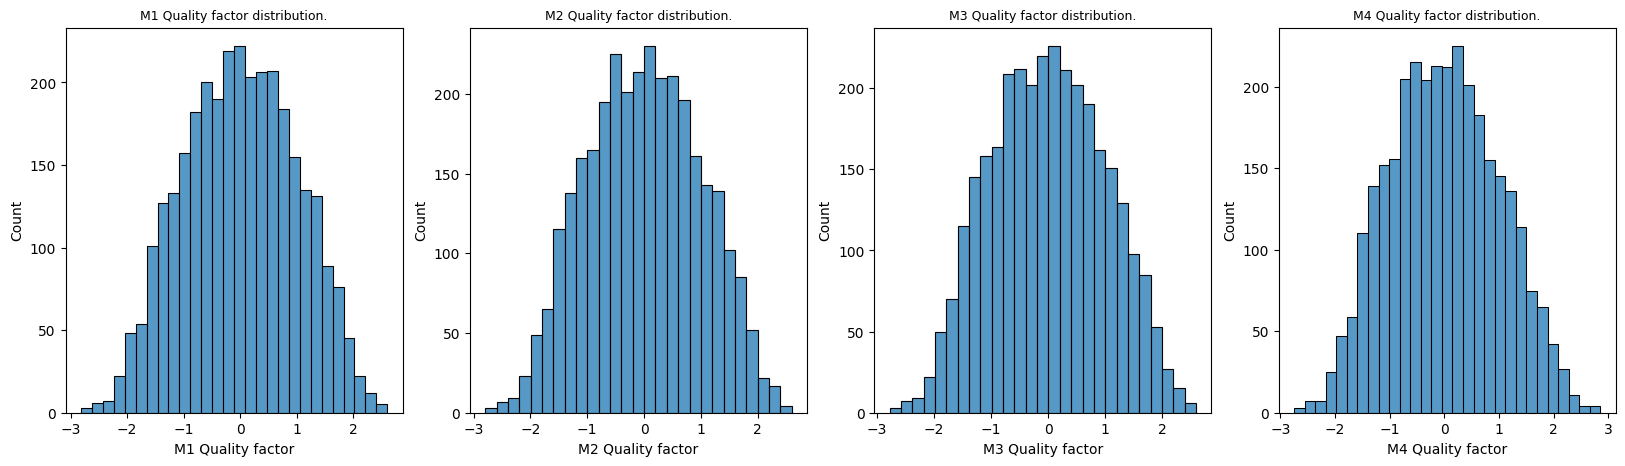

In [12]:
from classic_ml import plot_distribution

plot_distribution(df=y_train, param_name='Quality factor',
                  log_scale=False, font_size=0.25)

# Обучение моделей

### Импорт необходимых скриптов

In [16]:
%cd '/tmp/nems_ai-main/Scripts'
from classic_ml import get_elapsed_time, calculate_metrics
from classic_ml import plot_metrics, plot_metrics_dense, compare_models
from classic_ml import get_min_max_metrics

/tmp/nems_ai-main/Scripts


### `LinearRegressor`:

In [ ]:
model_lin = MultiOutputRegressor(LinearRegression(n_jobs=-2))
model_lin.fit(x_train, y_train)

MultiOutputRegressor(estimator=LinearRegression(n_jobs=-2))

In [ ]:
y_pred_train = model_lin.predict(x_train)
y_pred_val = model_lin.predict(x_val)
y_pred_test = model_lin.predict(x_test)

print("MSE на тренировочном наборе: {:.3f}".format(mean_squared_error(y_train, y_pred_train)))
print("MSE на валидационном наборе: {:.3f}".format(mean_squared_error(y_val, y_pred_val)))
print("MSE на тестовом наборе: {:.3f}".format(mean_squared_error(y_test, y_pred_test)))

print("R2 на тренировочном наборе: {:.3f}".format(r2_score(y_train, y_pred_train)))
print("R2 на валидационном наборе: {:.3f}".format(r2_score(y_val, y_pred_val)))
print("R2 на тестовом наборе: {:.3f}".format(r2_score(y_test, y_pred_test)))

print('Metrics dict:')
lin_metrics = calculate_metrics(y_true=y_test, y_pred=y_pred_test, param_names=list(y_train.columns))
for key, value in lin_metrics.items():
    print(key, ' : ', value)

lin_mse_test = mean_squared_error(y_test, y_pred_test)
lin_r2_test = r2_score(y_test, y_pred_test)

MSE на тренировочном наборе: 0.180
MSE на валидационном наборе: 0.203
MSE на тестовом наборе: 0.174
R2 на тренировочном наборе: 0.820
R2 на валидационном наборе: 0.806
R2 на тестовом наборе: 0.817
Metrics dict:
M1 Eigenfrequency (Hz)  :  [0.01536650493332292, 0.9842513549104402]
M1 Quality factor  :  [0.3273097789384859, 0.6459568999322045]
M1 Effective mass (kg)  :  [0.021038243158579623, 0.9781141393078813]
M1 TED (W)  :  [0.08082562558400361, 0.917205352286666]
M1 Noise (kg^2/s^3)  :  [0.32692959642436037, 0.66267541745]
M2 Eigenfrequency (Hz)  :  [0.019724414247065964, 0.9798393608366391]
M2 Quality factor  :  [0.31647917652087637, 0.6590850306170519]
M2 Effective mass (kg)  :  [0.021528830494149526, 0.9775793761027769]
M2 TED (W)  :  [0.07803749669232012, 0.9203057149856898]
M2 Noise (kg^2/s^3)  :  [0.4351771158708086, 0.548427894773986]
M3 Eigenfrequency (Hz)  :  [0.023020781315526092, 0.9765197200373597]
M3 Quality factor  :  [0.3035056315648507, 0.6734733586309503]
M3 Effective

### `RandomForestRegressor`:

In [ ]:
# Optuned params:
params = {'n_estimators': 757, 'max_depth': 14}

model_forest = RandomForestRegressor(n_estimators=params['n_estimators'],
                                     criterion='squared_error',
                                     random_state=42,
                                     max_depth = params['max_depth'],
                                     n_jobs=-1)
model_forest.fit(x_train, y_train)

RandomForestRegressor(max_depth=14, n_estimators=757, n_jobs=-1,
                      random_state=42)

In [ ]:
y_pred_train = model_forest.predict(x_train)
y_pred_val = model_forest.predict(x_val)
y_pred_test = model_forest.predict(x_test)

print("MSE на тренировочном наборе: {:.3f}".format(mean_squared_error(y_train, y_pred_train)))
print("MSE на валидационном наборе: {:.3f}".format(mean_squared_error(y_val, y_pred_val)))
print("MSE на тестовом наборе: {:.3f}".format(mean_squared_error(y_test, y_pred_test)))

print("R2 на тренировочном наборе: {:.3f}".format(r2_score(y_train, y_pred_train)))
print("R2 на валидационном наборе: {:.3f}".format(r2_score(y_val, y_pred_val)))
print("R2 на тестовом наборе: {:.3f}".format(r2_score(y_test, y_pred_test)))

print('Metrics dict:')
forest_metrics = calculate_metrics(y_true=y_test, y_pred=y_pred_test)
for key, value in forest_metrics.items():
    print(key, ' : ', value)

forest_mse_test = mean_squared_error(y_test, y_pred_test)
forest_r2_test = r2_score(y_test, y_pred_test)

MSE на тренировочном наборе: 0.005
MSE на валидационном наборе: 0.034
MSE на тестовом наборе: 0.034
R2 на тренировочном наборе: 0.995
R2 на валидационном наборе: 0.968
R2 на тестовом наборе: 0.964
Metrics dict:
M1 Eigenfrequency (Hz)  :  [0.021188084734227917, 0.9782850018234617]
M1 Quality factor  :  [0.04682085240067184, 0.949355012289853]
M1 Effective mass (kg)  :  [0.02126908992548383, 0.9778739918704926]
M1 Noise (kg^2/s^3)  :  [0.015654969619444344, 0.98396365403621]
M1 TED (W)  :  [0.04767425859599547, 0.9508099004949048]
M2 Eigenfrequency (Hz)  :  [0.018243731693035253, 0.9813527901488297]
M2 Quality factor  :  [0.04438714300810535, 0.952185664580031]
M2 Effective mass (kg)  :  [0.02166117768620547, 0.9774415466643527]
M2 Noise (kg^2/s^3)  :  [0.015309587767532015, 0.9843653794302533]
M2 TED (W)  :  [0.06090014017950994, 0.9368054902096808]
M3 Eigenfrequency (Hz)  :  [0.01591004660236583, 0.9837723862052304]
M3 Quality factor  :  [0.043674568532271474, 0.9530126999536817]
M3 Ef

 Вычисление минимального и максимального значения метрик:

In [ ]:
print(get_min_max_metrics(forest_metrics))

{'Eigenfrequency (Hz)': [0.014255325408524437, 0.021188084734227917, 0.9782850018234617, 0.9854751388725951], 'Quality factor': [0.043674568532271474, 0.07801454685592625, 0.9175416220149663, 0.9530126999536817], 'Effective mass (kg)': [0.02126908992548383, 0.022245836323040148, 0.9769253564932489, 0.9778739918704926], 'TED (W)': [0.04767425859599547, 0.07383507055783922, 0.9211266859265779, 0.9508099004949048], 'Noise (kg^2/s^3)': [0.015175341317409715, 0.022289681387847957, 0.9774843664444448, 0.9845196523858332]}


Время работы модели:

In [ ]:
print(get_elapsed_time(model=model_forest, x=x_train))

0.2390003204345703


### `XGBRegressor`:

In [19]:
# Optuned params:
params = {'max_depth': 5, 'learning_rate': 0.031324491931941124, 'n_estimators': 1386, 'min_child_weight': 2, 'gamma': 4.314314975364989e-06, 'subsample': 0.18490244522529528, 'reg_alpha': 2.8489984581757986e-06, 'reg_lambda': 0.0009295804483962102, 'n_jobs': -1, 'random_state': 42}

model_boost = XGBRegressor(**params)
model_boost.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=4.314314975364989e-06, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.031324491931941124, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=1386, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [20]:
y_pred_train = model_boost.predict(x_train)
y_pred_val = model_boost.predict(x_val)
y_pred_test = model_boost.predict(x_test)

print("MSE на тренировочном наборе: {:.3f}".format(mean_squared_error(y_train, y_pred_train)))
print("MSE на валидационном наборе: {:.3f}".format(mean_squared_error(y_val, y_pred_val)))
print("MSE на тестовом наборе: {:.3f}".format(mean_squared_error(y_test, y_pred_test)))

print("R2 на тренировочном наборе: {:.3f}".format(r2_score(y_train, y_pred_train)))
print("R2 на валидационном наборе: {:.3f}".format(r2_score(y_val, y_pred_val)))
print("R2 на тестовом наборе: {:.3f}".format(r2_score(y_test, y_pred_test)))

print('Metrics dict:')
boost_metrics = calculate_metrics(y_true=y_test, y_pred=y_pred_test)
for key, value in boost_metrics.items():
    print(key, ' : ', value)

boost_mse_test = mean_squared_error(y_test, y_pred_test)
boost_r2_test = r2_score(y_test, y_pred_test)

MSE на тренировочном наборе: 0.001
MSE на валидационном наборе: 0.011
MSE на тестовом наборе: 0.010
R2 на тренировочном наборе: 0.999
R2 на валидационном наборе: 0.989
R2 на тестовом наборе: 0.989
Metrics dict:
M1 Eigenfrequency (Hz)  :  [0.0006600640640848724, 0.9993235212088403]
M1 Quality factor  :  [0.01688020801813342, 0.9817410857814536]
M1 Effective mass (kg)  :  [0.0007376567964946384, 0.9992326234769231]
M1 Noise (kg^2/s^3)  :  [0.003717251463124153, 0.9961921912372782]
M1 TED (W)  :  [0.014548263885036841, 0.9849891625122943]
M2 Eigenfrequency (Hz)  :  [0.00045531677950082656, 0.9995346134398944]
M2 Quality factor  :  [0.016188794975091268, 0.9825612458805295]
M2 Effective mass (kg)  :  [0.0007679473841220686, 0.9992002417652489]
M2 Noise (kg^2/s^3)  :  [0.002983159391868504, 0.99695350613621]
M2 TED (W)  :  [0.02169850999313653, 0.9774840140243559]
M3 Eigenfrequency (Hz)  :  [0.000532717098908462, 0.999456649778658]
M3 Quality factor  :  [0.01641573468103721, 0.9823391260209

 Вычисление минимального и максимального значения метрик:

In [21]:
print(get_min_max_metrics(boost_metrics))

{'Eigenfrequency (Hz)': [0.00045531677950082656, 0.0006600640640848724, 0.9993235212088403, 0.9995346134398944], 'Quality factor': [0.016188794975091268, 0.04754406091980239, 0.9497477546910762, 0.9825612458805295], 'Effective mass (kg)': [0.0007376567964946384, 0.002045037209515097, 0.9978787713852444, 0.9992326234769231], 'TED (W)': [0.014548263885036841, 0.027475784942495734, 0.9706493648775529, 0.9849891625122943], 'Noise (kg^2/s^3)': [0.002983159391868504, 0.009087348510242727, 0.9908205323580894, 0.99695350613621]}


Время работы модели:

In [22]:
print(get_elapsed_time(model=model_boost, x=x_train))

0.18401098251342773


Визуализация метрик:

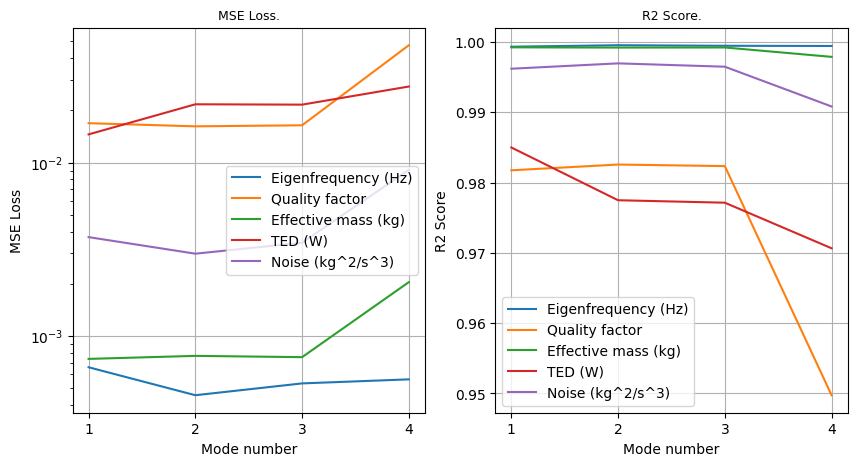

In [23]:
plot_metrics_dense(output_dict=boost_metrics,
                   apply_log_mse=True, apply_log_r2=False,
                   font_size=1.5)

### `TabNetRegressor`:

In [ ]:
# Optuned params:
params = {'n': 56, 'n_steps': 5, 'momentum': 0.04985768696802098}

model_tabnet = TabNetRegressor(n_d=params['n'], n_a=params['n'],
                               n_steps=params['n_steps'],
                               momentum=params['momentum'])
model_tabnet.fit(x_train.values, y_train.values,
                 max_epochs=100,
                 eval_metric=['mse'])

epoch 0  | loss: 6.25731 |  0:00:00s
epoch 1  | loss: 1.40754 |  0:00:01s
epoch 2  | loss: 0.81025 |  0:00:02s
epoch 3  | loss: 0.57877 |  0:00:03s
epoch 4  | loss: 0.4481  |  0:00:05s
epoch 5  | loss: 0.36854 |  0:00:07s
epoch 6  | loss: 0.29496 |  0:00:08s
epoch 7  | loss: 0.25362 |  0:00:09s
epoch 8  | loss: 0.22125 |  0:00:10s
epoch 9  | loss: 0.19602 |  0:00:11s
epoch 10 | loss: 0.17222 |  0:00:11s
epoch 11 | loss: 0.16243 |  0:00:13s
epoch 12 | loss: 0.1503  |  0:00:13s
epoch 13 | loss: 0.14232 |  0:00:14s
epoch 14 | loss: 0.13739 |  0:00:14s
epoch 15 | loss: 0.12503 |  0:00:15s
epoch 16 | loss: 0.12133 |  0:00:16s
epoch 17 | loss: 0.11821 |  0:00:18s
epoch 18 | loss: 0.11346 |  0:00:19s
epoch 19 | loss: 0.10983 |  0:00:21s
epoch 20 | loss: 0.10762 |  0:00:22s
epoch 21 | loss: 0.10077 |  0:00:23s
epoch 22 | loss: 0.10106 |  0:00:24s
epoch 23 | loss: 0.09416 |  0:00:25s
epoch 24 | loss: 0.08756 |  0:00:26s
epoch 25 | loss: 0.09088 |  0:00:27s
epoch 26 | loss: 0.08858 |  0:00:28s
e

In [ ]:
y_pred_train = model_tabnet.predict(x_train.values)
y_pred_val = model_tabnet.predict(x_val.values)
y_pred_test = model_tabnet.predict(x_test.values)

print("MSE на тренировочном наборе: {:.3f}".format(mean_squared_error(y_train, y_pred_train)))
print("MSE на валидационном наборе: {:.3f}".format(mean_squared_error(y_val, y_pred_val)))
print("MSE на тестовом наборе: {:.3f}".format(mean_squared_error(y_test, y_pred_test)))

print("R2 на тренировочном наборе: {:.3f}".format(r2_score(y_train, y_pred_train)))
print("R2 на валидационном наборе: {:.3f}".format(r2_score(y_val, y_pred_val)))
print("R2 на тестовом наборе: {:.3f}".format(r2_score(y_test, y_pred_test)))

print('Metrics dict:')
tabnet_metrics = calculate_metrics(y_true=y_test, y_pred=y_pred_test, param_names=list(y_train.columns))
for key, value in tabnet_metrics.items():
    print(key, ' : ', value)

tabnet_mse_test = mean_squared_error(y_test, y_pred_test)
tabnet_r2_test = r2_score(y_test, y_pred_test)

MSE на тренировочном наборе: 0.019
MSE на валидационном наборе: 0.021
MSE на тестовом наборе: 0.021
R2 на тренировочном наборе: 0.981
R2 на валидационном наборе: 0.980
R2 на тестовом наборе: 0.978
Metrics dict:
M1 Eigenfrequency (Hz)  :  [0.009320954869161588, 0.990447248039344]
M1 Quality factor  :  [0.025705438855195106, 0.9721950462634762]
M1 Effective mass (kg)  :  [0.007898795744265977, 0.9917829667624121]
M1 Noise (kg^2/s^3)  :  [0.011582572795956368, 0.9881352599831279]
M1 TED (W)  :  [0.03380553115882391, 0.965119595133781]
M2 Eigenfrequency (Hz)  :  [0.009165283796357697, 0.9906320168937006]
M2 Quality factor  :  [0.023550079493577233, 0.9746315864513466]
M2 Effective mass (kg)  :  [0.0075678141761091585, 0.9921187026200645]
M2 Noise (kg^2/s^3)  :  [0.009896918130235079, 0.9898929636691963]
M2 TED (W)  :  [0.03984545098217288, 0.9586533998974308]
M3 Eigenfrequency (Hz)  :  [0.008009041439771904, 0.9918310967529411]
M3 Quality factor  :  [0.023979249332670326, 0.974201916100278

 Вычисление минимального и максимального значения метрик:

In [ ]:
print(get_min_max_metrics(tabnet_metrics))

{'Eigenfrequency (Hz)': [0.007972882998982796, 0.009320954869161588, 0.990447248039344, 0.9918763679518656], 'Quality factor': [0.023550079493577233, 0.06617585839569008, 0.930054660765342, 0.9746315864513466], 'Effective mass (kg)': [0.00723485913433594, 0.01033870721027203, 0.9892761063358798, 0.9924666612429406], 'TED (W)': [0.03380553115882391, 0.052705828341150465, 0.9436977127421453, 0.965119595133781], 'Noise (kg^2/s^3)': [0.009896918130235079, 0.019016910560459448, 0.9807903135945447, 0.9898929636691963]}


Функция для подсчета времени для `TabNet Regressor`:

In [ ]:
def get_elapsed_time_tabnet(model, x, num_samples=200):
    """
    Returns time elapsed during evaluation.

    Parameters
    ----------
    model : model object
        Trained model evaluation time to be measured for.
    x : pd.DataFrame
        Dataframe that contains data to input into the model.
    num_samples : int
        Number of samples to be used for evaluation (default 200).

    Returns
    ----------
    elapsed_time : float
        Elapsed time.
    """
    samples_x = x.iloc[:num_samples, :]
    time_start = time()
    samples_y = model.predict(samples_x.values)
    time_stop = time()

    elapsed_time = time_stop - time_start

    return elapsed_time

In [ ]:
print(get_elapsed_time_tabnet(model=model_tabnet, x=x_train))

0.029131412506103516


# Сравнение качества предсказаний разных моделей

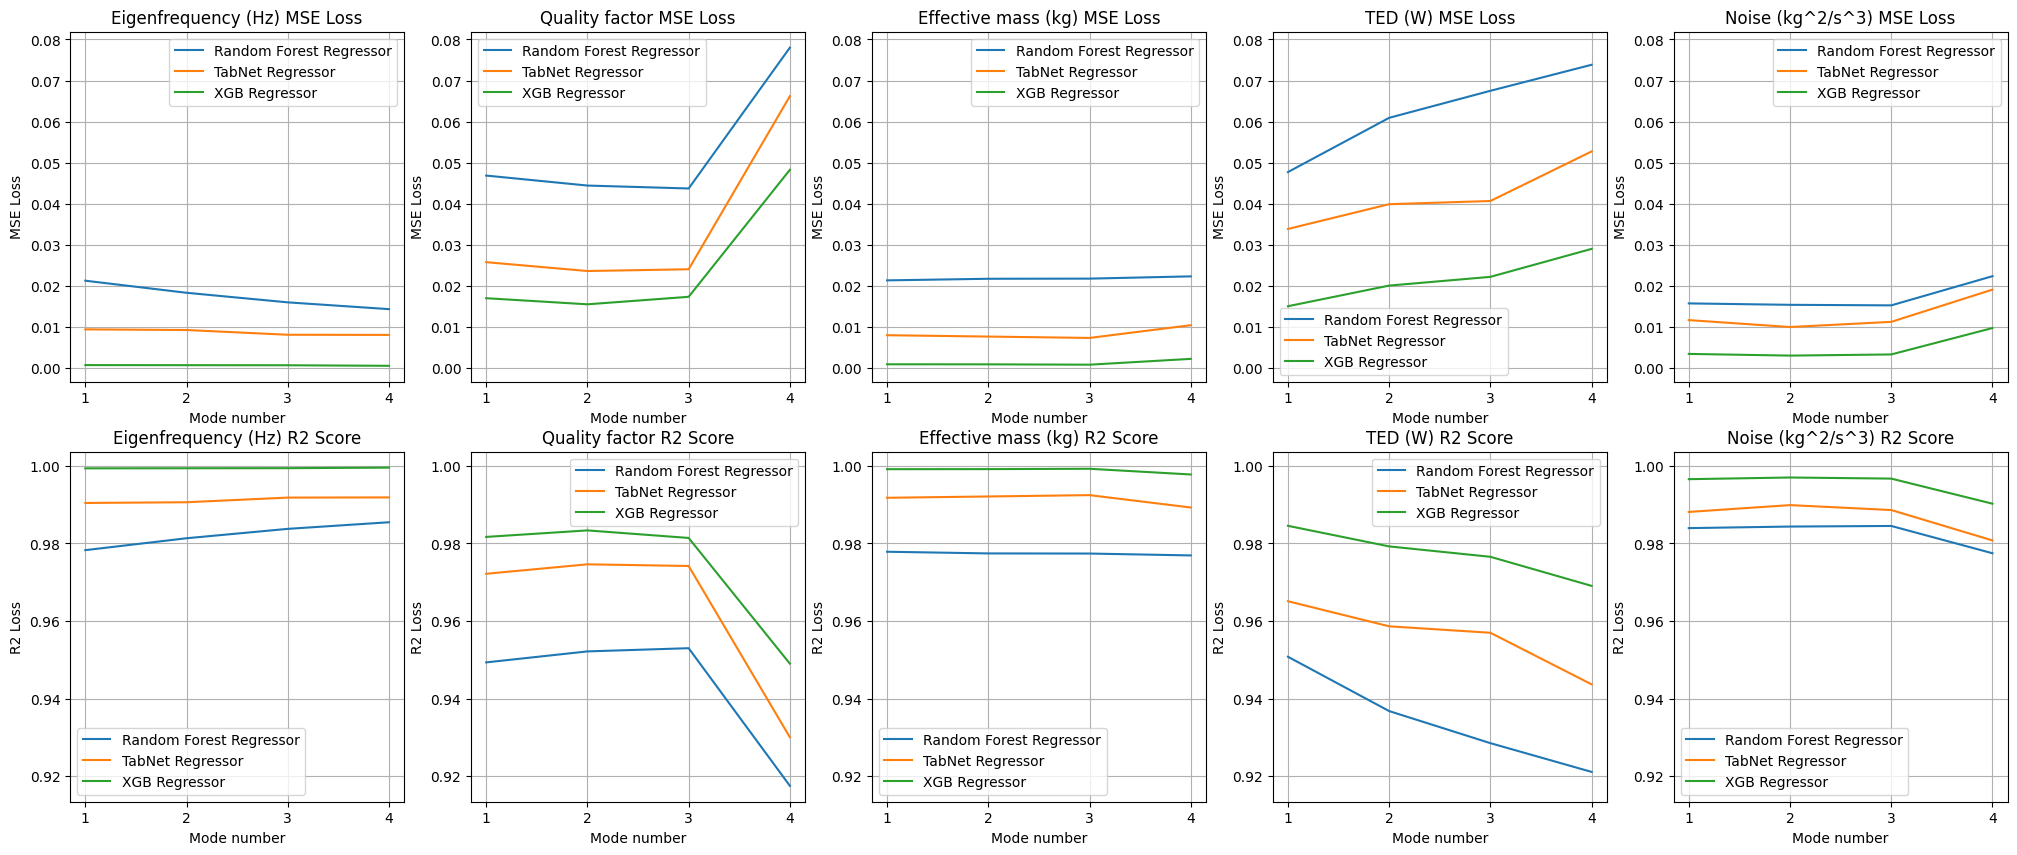

In [ ]:
model_names = [#'Linear Regressor',
               'Random Forest Regressor', 'TabNet Regressor', 'XGB Regressor']
dict_list = [#lin_metrics,
             forest_metrics, tabnet_metrics, boost_metrics]

compare_models(dict_list, model_names,
               apply_log_mse=False, apply_log_r2=False)

# Дополнительное тестирование

## Анализ реальных устройств

Пробуем дать модели на вход тестовые данные: либо параметры реально существующего устройства, либо параметры устройств, сгенерированных в FEM, но лежащие на границах распределений параметров.

In [25]:
gate_U = 0
gate_D = 500
pretension = 0
pretension_lanc = 700e6

x_real = pd.DataFrame([[70, 200, 100, 30, 1, gate_D, gate_U, pretension],
                       [30, 170, 60, 80, 1, gate_D, gate_U, pretension],
                       [30, 300, 100, 30, 1, gate_D, gate_U, pretension_lanc],
                       [150, 300, 100, 30, 1, gate_D, gate_U, pretension_lanc]]) # это параметры реально изготовленного устройства
x_real.columns = x_train.columns

#x_real = x_test[x_test['Beam length (um)']>0]
#x_real = x_real[x_real['Beam length (um)']<0.04]

y_real_ = pd.DataFrame(np.ones(shape=(1, 20)))
y_real_.columns = y_train.columns
#y_real_.iloc[0, 0] = 2.166e6
#y_real_.iloc[1, 0] = 6.3e6
#y_real_.iloc[2, 0] = 11.6e6
#y_real_.iloc[3, 0] = 1.66e6

x_real = s.transform_real_x(x_real)

y_real_pred = model_boost.predict(x_real)

x_real, y_real_pred = s.reverse_transform(x_real, y_real_pred, concat_required=False)
y_real_pred = pd.DataFrame(y_real_pred)
y_real_pred.columns = y_train.columns

real_pred = pd.concat([x_real, y_real_pred], axis=1)
real_pred.head()

,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa),M1 Eigenfrequency (Hz),M1 Quality factor,...,M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 Noise (kg^2/s^3),M3 TED (W),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 Noise (kg^2/s^3),M4 TED (W)
0,70.0,200.0,100.0,30.0,1.0,500.0,0.0,0.0,2.123142e+06,7.321816e+05,...,6643789.0,9.461973e+05,2.525695e-15,2.068669e-28,3.311606e-12,8652810.0,6.241042e+05,2.682173e-15,6.735282e-28,4.857052e-12
1,30.0,170.0,60.0,80.0,1.0,500.0,0.0,0.0,5.313334e+06,1.734736e+06,...,17461754.0,1.558977e+06,9.174725e-16,4.628838e-28,3.199641e-12,25888730.0,9.924658e+05,1.008687e-15,2.720272e-27,4.647926e-12
2,30.0,300.0,100.0,30.0,1.0,500.0,0.0,700000000.0,1.013740e+07,1.345416e+07,...,32674668.0,8.873410e+06,1.749059e-15,3.009423e-28,4.089413e-12,45373040.0,7.449286e+06,1.709252e-15,1.022570e-27,4.760309e-12
3,150.0,300.0,100.0,30.0,1.0,500.0,0.0,700000000.0,1.879369e+06,1.554773e+06,...,5658313.0,1.667852e+06,8.126304e-15,1.146852e-28,4.252329e-12,7542516.5,9.237891e+05,8.441456e-15,2.024413e-28,6.556086e-12


Например, для экспериментального устройства с входными параметрами как в первой строке в таблице выше, реальное значение резонансной частоты составляет: $f^{real}_{0} = 2.166$ МГц. Относительная ошибка вычислений: $\delta_{f_{0}} = \frac{f^{real}_{0} - f^{pred}_{0}}{f^{real}_{0}} = 0.02$, что соответствует ошибке в $ 2\%$.